In [3]:
import urllib.request as ur
import json
import re
import os
import timeit
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# инициализируем все функции 

def cnt(x):
    return len(x.split())

    
def fix_text(text):
    return re.sub('\[.*?\][\W]?| [\W]* |http.*? |http.*[\w]+[\W]*|<.*?>', ' ', text)


def time_it(st):
    return round(timeit.default_timer() - st, 2)


# получим записи со стены
# с установленным оффсетом
def get_req():
    cnt = 0
    out = []
    offs = [x-1 for x in range(1, offset_bound, 100)]
    st_time = timeit.default_timer()
    for off in offs:
        req = ur.urlopen(ur.Request('https://api.vk.com/method/wall.get?domain=' + str(comm_id) \
                                    + '&count=' + str(offset_bound-off) + '&offset='+str(off))).read().decode()
        data = json.loads(req)['response']
        for i in range(1, len(data)):
            out.append(data[i])
            cnt += 1
    
    print('Got ' + str(cnt) + ' posts in ' + str(time_it(st_time)) + ' s.\n')
    return tuple(out)


def get_text(resp):
    # returns post lengths as [0], post text as [1]
    return len(fix_text(resp['text']).split()), fix_text(resp['text'])


# получим комментарии и инфо об авторах
# с установленным оффсетом
def get_coms(own_id, pst_id):
    # returns coms lengths mean as [0], coms texts tuple as [1]
    offs = [x-1 for x in range(1, offset_bound, 100)]
    coms = []
    coms_len = []
    reqst = 'https://api.vk.com/method/wall.getComments?' \
          'owner_id=' + str(own_id) + '&post_id=' + str(pst_id) + '&offset='
    
    for off in offs:
        req = json.loads(ur.urlopen(ur.Request(reqst+str(off)+'&count='+str(offset_bound-off))).read().decode())
        for i in range(1, len(req['response'])):
            text = fix_text(req['response'][i]['text'])
            coms.append(text)
            com_len = cnt(text)
            coms_len.append(com_len)
            if '-' not in str(req['response'][i]['uid']):
                if com_len > 0: 
                    ids.append(req['response'][i]['uid'])
                    lens.append(com_len)
                    #ling_inf(com_len, user_data, 'c')
        
    return round(float(np.array(coms_len).mean()), 2), tuple(coms)


# запись текстов в root
def wr_post(text, coms, pst_id):
    def wr(x, name, path):
        #name -- name of the file
        f = open(path + '\\' + name + '.txt', 'w', encoding='utf-8')
        f.write(x)
        f.close()
        return
    
    path = root + '\\' + str(pst_id)
    if os.path.exists(path) != True:
            os.makedirs(path)
    wr(text, 'text', path)
    if coms != '':
        coms_path = path + '\\comments'
        if os.path.exists(coms_path) != True:
            os.makedirs(coms_path)
        for i in range(len(coms)):
            wr(coms[i], str(i+1), coms_path)
    
    return #print('Wrote post: ' + str(pst_id))


# для извлечения инфо
# о городе/возрасте авторов
# из списка айди всех авторов 
def get_users(usr_ids, usr_lns, if_label):
    """ usr_ids=list of user ids
        usr_lns=lengths of user post
        if_label=True if to decode cities
        matched indecies here: e.g.
        usr_lns[i] euals to the lengths
        of usr_ids[i] post"""
    
    dict_ages = {}
    dict_cities = {}
    bound = 100
    st_time = timeit.default_timer()
    global pl_cnt
    pl_cnt = 0
    
    def fill_dicts(age, city, i):
        global pl_cnt
        
        if age != -1:
            if age not in dict_ages:
                dict_ages[age] = []
            dict_ages[age].append(usr_lns[i])
            pl_cnt += 1
        
        if city != -1:
            if city not in dict_cities:
                dict_cities[city] = []
            dict_cities[city].append(usr_lns[i])
        return
        
    def get_age(inf):
        # age: day, month, year
        def get_cur_time():
            cur = time.localtime()
            return cur[2], cur[1], cur[0]

        if 'bdate' in inf:
            age = str(inf['bdate'])
            
            if age.count('.') < 2:
                return -1
            else:
                cur = get_cur_time()
                if int(age.split('.')[1]) >= cur[1] and int(age.split('.')[0]) >= cur[0]:
                        return cur[2] - int(age.split('.')[2])
                else:
                    return cur[2] - int(age.split('.')[2]) - 1
        else:
            return -1
    
    def get_city(inf, if_label):
        def num_to_name(ids):
            #print(str(ids)+'income ids')
            if ids == '':
                return -1
            elif type(ids) == str:
                return ids
            elif int(ids) < 1:
                return -1
            elif if_label:
                req = json.loads(ur.urlopen(ur.Request('https://api.vk.com/method/database.getCitiesById?' \
                                 'city_ids='+ str(ids))).read().decode())
                return req['response'][0]['name']
            else:
                return ids
                
        if 'home_town' in inf:
            town = num_to_name(inf['home_town'])
            if town != -1:
                return town
            else:
                if 'city' in inf:
                    return num_to_name(inf['city'])
                else:
                    return -1
        else:
            return -1
    
    t = 0
    for off in [x for x in range(0, len(usr_ids), bound)]:
        req = ur.Request('https://api.vk.com/method/users.get?user_ids='+ ','.join(map(str, usr_ids[off:off+bound])) + \
                          '&count='+str(bound)+'&offset='+str(off)+'&fields=bdate,home_town,city')
    
        inf = json.loads(ur.urlopen(req).read().decode())['response']
        t += len(inf)
        for i in range(len(inf)):
            age = get_age(inf[i])
            city = get_city(inf[i], if_label)
            fill_dicts(age, city, i)
    
    print('Socio-info log:\n' \
          'People: approx. ' + str(pl_cnt) + '\n' \
          'Cities: ' + str(len(dict_cities)) + '\n' \
          'runtime: ' + str(time_it(st_time)) + ' s.')
    
    return dict_ages, dict_cities, t



def main(data):
    # data -- wall.get запрос
    
    global ids
    ids = []
    
    global lens
    lens = []
    
    dict_posts = {}
    
    coms_cnt = 0
    post_cnt = 0

    st_time = timeit.default_timer()

    # соберем посты и комменты
    for resp in data:
        pst_id = resp['id']
        post_data = get_text(resp)
        if resp['comments']['count'] != 0:
            coms_data = get_coms(resp['from_id'], pst_id)
            coms_cnt += len(coms_data[1])
        else:
            coms_data = [0, 0]

        # запишем пост и кооменты,
        # если пост не пустой
        if post_data[0] > 0:
            post_cnt += 1
            try:
                wr_post(post_data[1], coms_data[1], pst_id)
            except:
                print('Bad data to write for post: ' + str(pst_id))

            # получим инфо об авторе поста
            # если пост не от сообщ.
            if '-' not in str(resp['from_id']):
                ids.append(resp['from_id'])
                lens.append(post_data[0])
                #ling_inf(post_data[0], get_user(resp['from_id']), 'p')

            # если есть подписанный автор
            if 'signer_id' in resp and '-' not in str(resp['signer_id']):
                ids.append(resp['signer_id'])
                lens.append(post_data[0])
                #ling_inf(post_data[0], get_user(resp['signer_id']), 'p')

        # заполним словарь для графика
        # пост/коммент
        dict_posts[pst_id] = (post_data[0], coms_data[0])

    print('\nSuccessfully processed:\n' \
          'Posts: ' + str(post_cnt) + '\n' \
          'Comments: ' + str(coms_cnt) + '\n' \
          'runtime: ' + str(time_it(st_time)) + ' s.')
    return dict_posts

In [11]:
# обозначим root и создадим, если нужно,
# дир. для записи текстов
global root
root = 'C:\\Users\\Artem\\Desktop\\all\\py_proj\\vk_plt'
if os.path.exists(root) != True:
    os.makedirs(root)
    
global offset_bound
offset_bound = 150

# обозначим айди сообщества
global comm_id
comm_id = 'friday_ru'

# исправление кривого ввода чистого id сообщества
if re.search('[a-zA-Z]', comm_id) == None and '-' not in comm_id:
    comm_id = '-' + comm_id

In [12]:
# получим стену нужного сообщества
data = get_req()

Got 150 posts in 0.63 s.



In [13]:
# получим словарь с данными 
# о длине постов/комментов,
# список айди авторов -- ids (global)
# соответств. список длин постов/комментов -- lens (global)
# и выведем лог процесса
# try-except в главной ф-ии в основном ловит репосты без какого-либо текста
posts_info = main(data)

Bad data to write for post: 230159
Bad data to write for post: 229717
Bad data to write for post: 229480
Bad data to write for post: 228078

Successfully processed:
Posts: 147
Comments: 4246
runtime: 78.53 s.


In [14]:
# получим инфо и длинах постов и комментов
# в зависимости от города и возраста автора
# если if_label = False, 
# получим только чистые айди городов
# и меньший общий рантайм
soc_inf = get_users(ids, lens, True)
ages_info = soc_inf[0]
cities_info = soc_inf[1]

Socio-info log:
People: approx. 1043
Cities: 307
runtime: 32.56 s.


In [25]:
# инициализируем ф-ию для визулизации
# и определим путь сохранения картинок графиков
plot_root = root + '\\' + 'PLOTS'
if os.path.exists(plot_root) != True:
    os.makedirs(plot_root)

def plot_it(data, data_type, x_lbl, y_lbl, c, alpha, size):
    """ data_type='post', 'age', 'city'
        c=color
        alpha=alpha
        size=plot size (tuple)"""
    
    plot = plt.figure(figsize=size)
    
    if data_type == 'posts':
        x = [int(data[k][0]) for k in data]
        y = [float(data[k][1]) for k in data]
    elif data_type == 'ages':
        x = [int(k) for k in data]
        y = [np.array(data[k]).mean() for k in data]
    else:
        x = range(len([k for k in data]))
        y = [np.array(data[k]).mean() for k in data]
        
    plt.bar(x, y, color=c, alpha=alpha)
    plt.xlabel(x_lbl)
    plt.ylabel(y_lbl)
    if data_type == 'cities':
        plt.xticks(range(len([k for k in data])), [k for k in data], rotation=90)
    
    plot.savefig(plot_root + '\\' + data_type + '.pdf')
    
    return print('Plot ' + data_type + '.pdf saved to: ' + plot_root)

Plot posts.pdf saved to: C:\Users\Artem\Desktop\all\py_proj\vk_plt\PLOTS


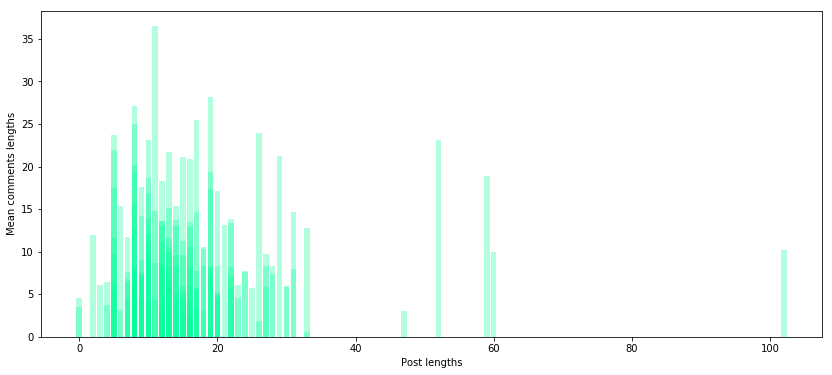

In [18]:
# длина поста/среднее комментов
plot_it(posts_info, 'posts', 'Post lengths', 'Mean comments lengths', '#00ff99', 0.3, (14,6))

Plot ages.pdf saved to: C:\Users\Artem\Desktop\all\py_proj\vk_plt\PLOTS


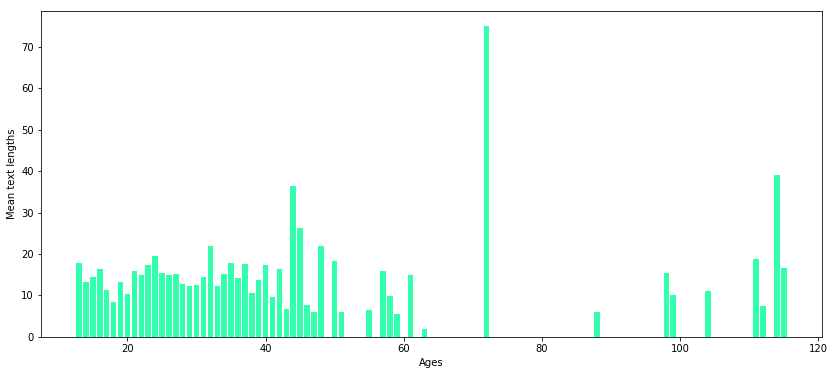

In [20]:
# возраст/средняя длина текста
plot_it(ages_info, 'ages', 'Ages', 'Mean text lengths', '#00ff99', 0.8, (14,6))

Plot cities.pdf saved to: C:\Users\Artem\Desktop\all\py_proj\vk_plt\PLOTS


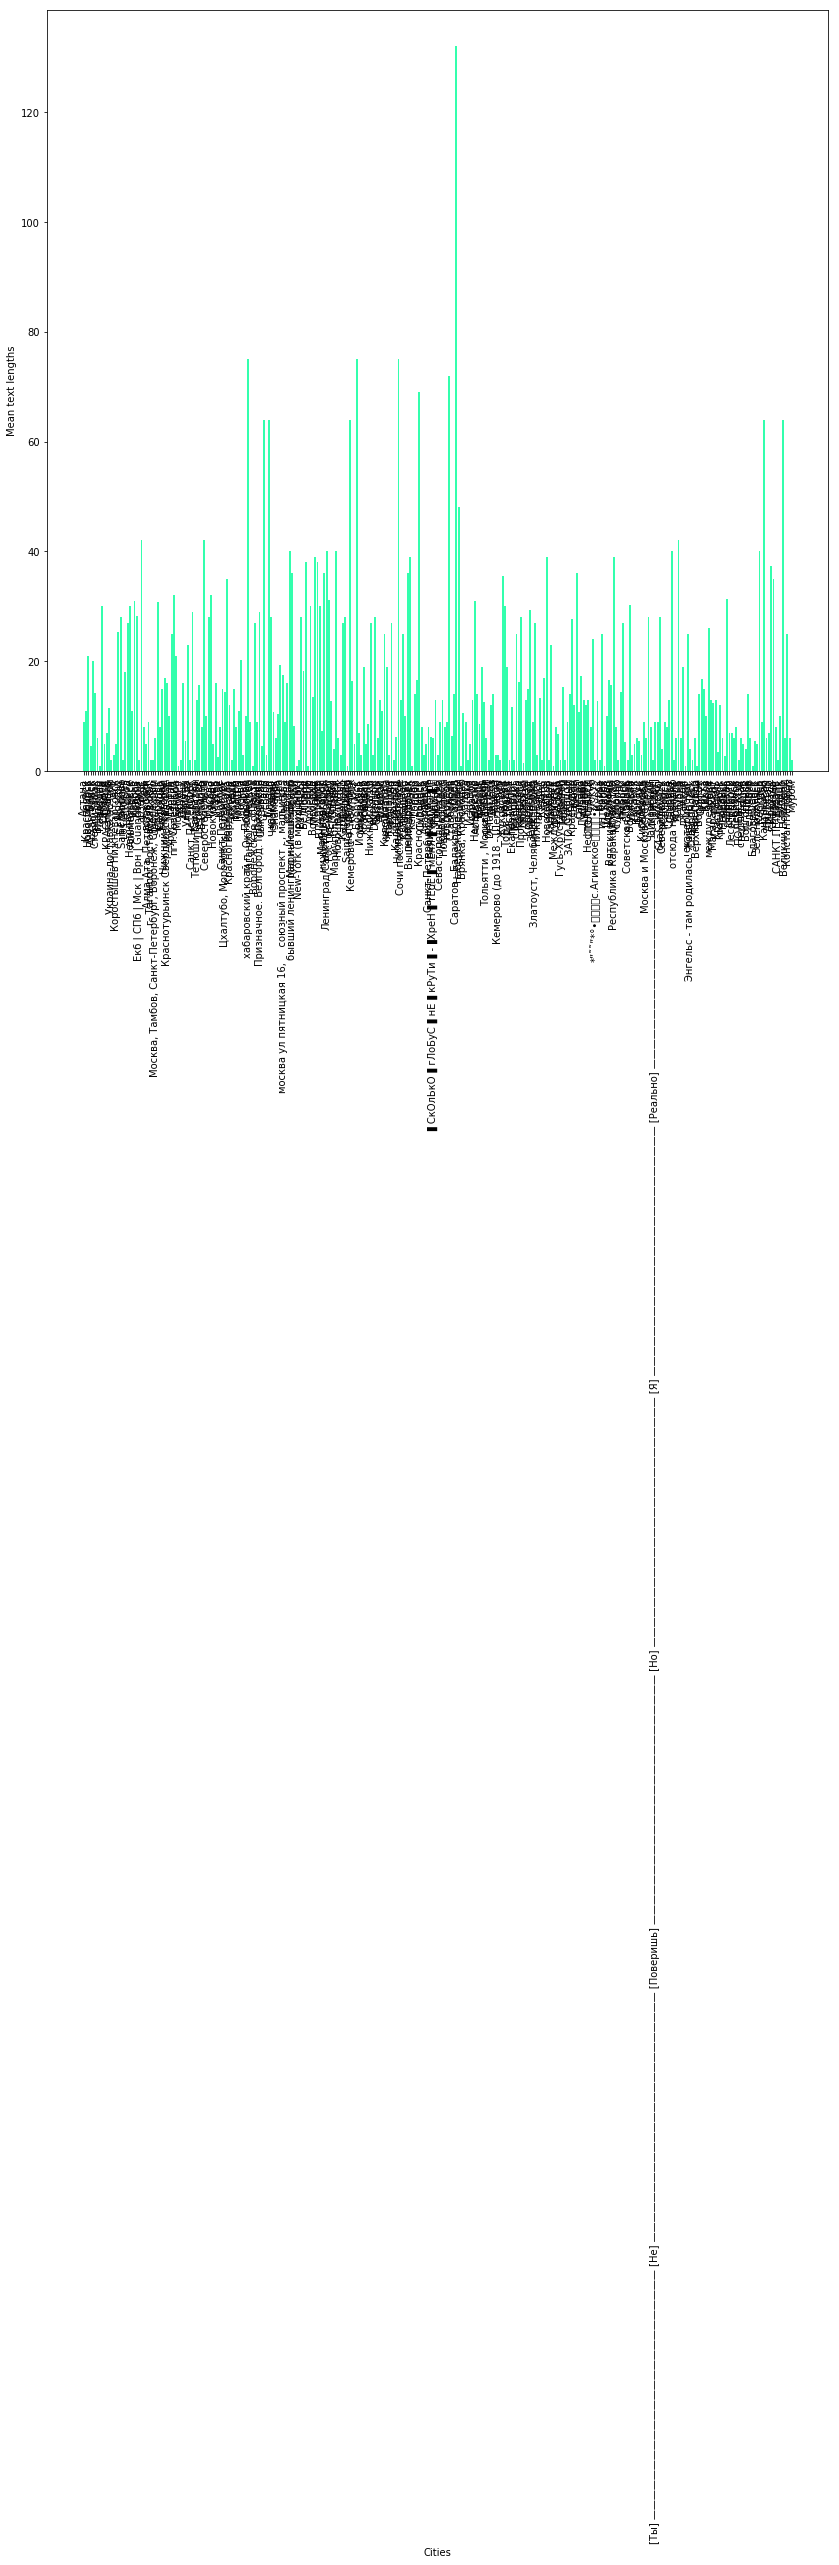

In [26]:
# город/средняя длина текста
plot_it(cities_info, 'cities', 'Cities', 'Mean text lengths', '#00ff99', 0.8, (14,14))